In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyloki.config import ParamLimits, PulsarSearchConfig
from pyloki.core.basic import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig


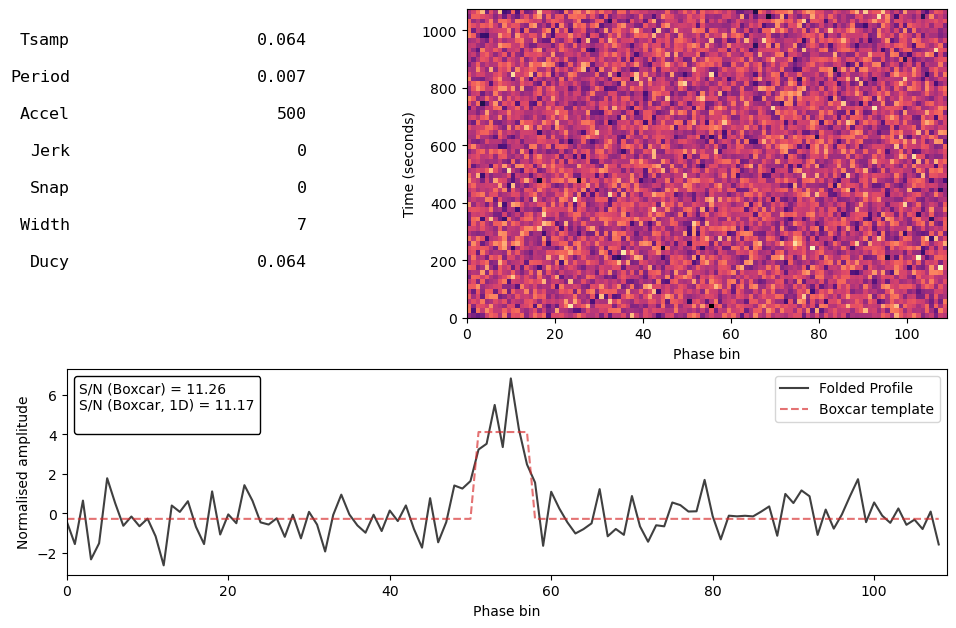

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 500
nsamps = 2**24
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(
    period=pulsar_period, dt=dt, nsamps=nsamps, snr=10, ducy=0.1, mod_kwargs=mod_kwargs
)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1  # cfg.tol_bins
fold_bins = 64  # cfg.fold_bins
p = ParamLimits.from_upper([accel, cfg.freq], (-accel * 3, accel * 3), cfg.tobs)
p = ParamLimits.from_taylor((135.0, 145.0), (-1500.0, 1500.0))
print(p.limits)
bseg_brute = cfg.nsamps // 8192
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(
    nsamps=cfg.nsamps,
    tsamp=cfg.dt,
    nbins=fold_bins,
    tol_bins=tol_bins,
    param_limits=p.limits,
    bseg_brute=bseg_brute,
    bseg_ffa=bseg_ffa,
    prune_poly_order=2,
)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

[(-1500.0, 1500.0), (135.0, 145.0)]


2025-03-27 18:34:39 INFO     - pyloki.ffa - FFA initialize: Grid sizes: [1.50432912e+07 2.38418579e-01]

                    INFO     - pyloki.ffa - ffa level:  0, leaves: 5.36, fold dims: (8192, 1, 41, 2, 64)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 0.173 seconds

Output()

2025-03-27 18:34:44 INFO     - pyloki.ffa - ffa level:  1, leaves:  6.38, fold dims: (4096, 1, 83, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  2, leaves:  7.38, fold dims: (2048, 1, 167, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  3, leaves:  8.39, fold dims: (1024, 1, 335, 2, 64)

2025-03-27 18:34:45 INFO     - pyloki.ffa - ffa level:  4, leaves:  9.39, fold dims: (512, 1, 671, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  5, leaves: 10.39, fold dims: (256, 1, 1342, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  6, leaves: 11.39, fold dims: (128, 1, 2684, 2, 64)

                    INFO     - pyloki.ffa - FFA complete: Grid sizes: [3.6726785e+03 3.7252903e-03]

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 5.775 seconds

In [4]:
branching_pattern = generate_branching_pattern(
    dyp.param_arr,
    dyp.dparams_limited,
    dyp.cfg.param_limits,
    dyp.cfg.tseg_ffa,
    dyp.nsegments - 1,
    dyp.cfg.nbins,
    dyp.cfg.tol_bins,
    0,
)
branching_pattern

array([4, 3, 4, 1, 1, 9, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
target_snr = 8
thresholds = np.minimum(
    thresholding.bound_scheme(dyp.nsegments - 1, target_snr),
    thresholding.trials_scheme(branching_pattern, trials_start=1),
)

ref_segs = [0, 20, 40, 60]
# Make sure the output directory exists
result_file = prune_dyp_tree(
    dyp,
    ref_segs,
    thresholds,
    max_sugg=2**18,
    outdir="accel_test/",
    file_prefix="test_accel",
    kind="taylor",
    n_workers=4,
)

2025-03-27 18:38:55 INFO     - pyloki.prune - Starting Pruning for 4 runs, with 4 workers

Output()

2025-03-27 18:38:59 INFO     - worker_000 - Initializing pruning run with ref segment: 0

                    INFO     - worker_000 - prune_initialize finished, Elapsed time: 0.032 seconds

2025-03-27 18:39:00 INFO     - worker_020 - Initializing pruning run with ref segment: 20

                    INFO     - worker_020 - prune_initialize finished, Elapsed time: 0.027 seconds

2025-03-27 18:39:01 INFO     - worker_040 - Initializing pruning run with ref segment: 40

                    INFO     - worker_040 - prune_initialize finished, Elapsed time: 0.027 seconds

2025-03-27 18:39:02 INFO     - worker_060 - Initializing pruning run with ref segment: 60

                    INFO     - worker_060 - prune_initialize finished, Elapsed time: 0.027 seconds

2025-03-27 18:40:03 INFO     - worker_040 - Pruning run complete for ref segment: 40

                    INFO     - worker_040 - Pruning stats: Score: 6.70, Leaves: 9.33

                    INFO     - worker_040 - Pruning time: Total: 44.1s (resolve: 29% | shift_add: 28% | branch: 16%
                             | score: 14%)

2025-03-27 18:40:05 INFO     - worker_000 - Pruning run complete for ref segment: 0

                    INFO     - worker_000 - Pruning stats: Score: 9.66, Leaves: 9.77

                    INFO     - worker_000 - Pruning time: Total: 46.2s (resolve: 29% | shift_add: 27% | branch: 17%
                             | score: 14%)

2025-03-27 18:40:14 INFO     - worker_020 - Pruning run complete for ref segment: 20

                    INFO     - worker_020 - Pruning stats: Score: 10.00, Leaves: 9.88

                    INFO     - worker_020 - Pruning time: Total: 55.6s (resolve: 31% | shift_add: 27% | branch: 19%
                             | score: 10%)

2025-03-27 18:40:18 INFO     - worker_060 - Pruning run complete for ref segment: 60

                    INFO     - worker_060 - Pruning stats: Score: 6.29, Leaves: 9.15

                    INFO     - worker_060 - Pruning time: Total: 57.1s (resolve: 31% | shift_add: 27% | branch: 19%
                             | score: 12%)

2025-03-27 18:40:18 INFO     - pyloki.prune - Pruning complete. Results saved to                                   
                             accel_test/test_accel_pruning_nstages_128_results.h5

In [10]:
pgram = ScatteredPeriodogram.load(result_file)
acc_true = cfg.mod_kwargs["acc"]
freq_true = cfg.freq
print(f"True params, a: {acc_true:.3f}, f: {freq_true:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, a: 500.000, f: 142.8571428571
Top candidates:
dparams: daccel: 0.2572016461, dfreq: 4.599123825e-05
Run: 020, S/N: 10.00, accel: 499.87, freq: 142.857104
Run: 020, S/N: 9.75, accel: 500.39, freq: 142.857148
Run: 020, S/N: 9.70, accel: 499.87, freq: 142.857150
Run: 000, S/N: 9.66, accel: 499.87, freq: 142.857096
Run: 020, S/N: 9.35, accel: 500.13, freq: 142.857149
Run: 020, S/N: 9.34, accel: 499.61, freq: 142.857152
Run: 000, S/N: 9.34, accel: 500.39, freq: 142.857135
Run: 020, S/N: 9.26, accel: 500.39, freq: 142.857102
Run: 020, S/N: 9.21, accel: 500.64, freq: 142.857146
Run: 000, S/N: 9.15, accel: 499.61, freq: 142.857123


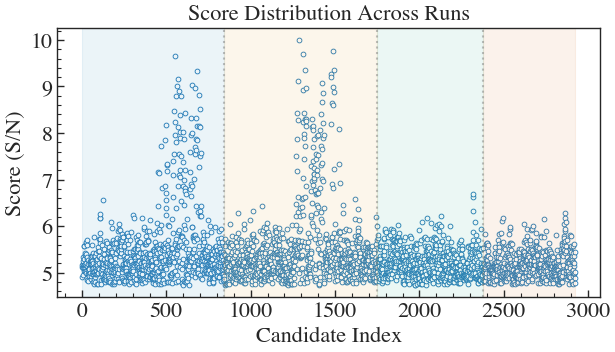

In [ ]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

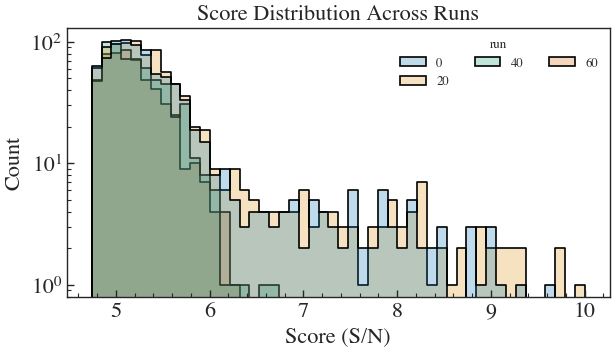

In [ ]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

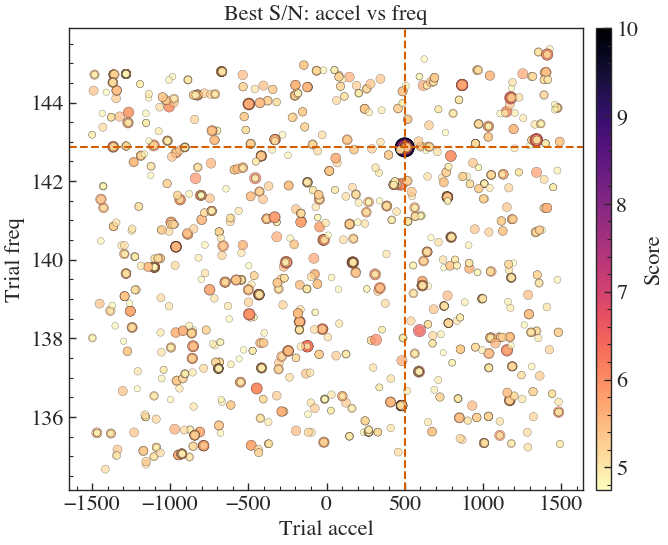

In [13]:
pgram.plot_correlation(
    "accel", "freq", true_values={"accel": acc_true, "freq": freq_true}, run_id=None
)
plt.show()